# Import necessary libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Suppress the warnings (optional)
import warnings
warnings.filterwarnings('ignore')

base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
train_path = os.path.join(base_path, "train")

2025-10-18 07:35:46.395680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760772946.624718      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760772946.691583      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"



In [3]:
# import os

# base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
# train_path = f"{base_path}/train"

# # Pick the first sample ID folder
# patch_id = os.listdir(train_path)[0]
# print("Example patch folder:", patch_id)

# # List what files are actually inside it
# print("Files inside:", os.listdir(f"{train_path}/{patch_id}"))


def load_data(train_path, bands_range=range(8,17), max_patches=None):
    images, masks = [], []
    #List all patch folders
    patch_ids = os.listdir(train_path)
    #Limit no: of patches
    if max_patches:
        patch_ids = patch_ids[:max_patches]
    #Load bands for each patch
    for patch_id in patch_ids:
        patch_dir = os.path.join(train_path, patch_id)
        
        # Load bands and normalize individually
        band_list = []
        for b in bands_range:
            band = np.load(os.path.join(patch_dir, f"band_{b:02d}.npy"))
            if band.ndim > 2:
                band = band[...,0]
            band = band / (band.max() + 1e-6)  # per-band normalization
            band_list.append(band)
        img = np.stack(band_list, axis=-1)
        
        # Load mask
        mask = np.load(os.path.join(patch_dir, "human_pixel_masks.npy"))
        if mask.ndim > 2:
            mask = mask[...,0]
        mask = np.where(mask>0,1,0)
        
        if mask.max() > 0:  # only patches with contrails
            images.append(img)
            masks.append(mask)
    
    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)[..., np.newaxis]
    return images, masks

# Load dataset (can increase max_patches later)
X, y = load_data(train_path, max_patches=200)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)



X_train: (69, 256, 256, 9) y_train: (69, 256, 256, 1)
X_val: (18, 256, 256, 9) y_val: (18, 256, 256, 1)


### Data visualization

Example patch folder: 1284412112608546821
Stacked image shape: (256, 256, 9)
Mask shape: (256, 256)


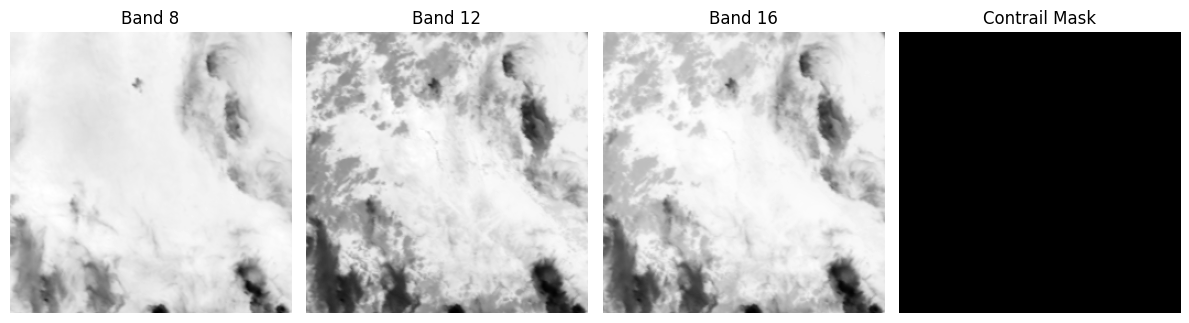

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
train_path = f"{base_path}/train"

# Pick one patch
patch_id = os.listdir(train_path)[0]
print("Example patch folder:", patch_id)

bands = []
for b in range(8, 17):  # bands 8–16
    band = np.load(f"{train_path}/{patch_id}/band_{b:02d}.npy")
    
    # Ensure 2D by taking the first channel if it's multi-channel
    if band.ndim > 2:
        band = band[..., 0]
    bands.append(band)

# Stack into a (H, W, 9) array
image = np.stack(bands, axis=-1)
print("Stacked image shape:", image.shape)  # should be (256, 256, 9)

# Load the contrail mask
mask = np.load(f"{train_path}/{patch_id}/human_pixel_masks.npy")
if mask.ndim > 2:
    mask = mask[..., 0]
print("Mask shape:", mask.shape)

# Visualize 3 selected bands and mask
plt.figure(figsize=(12, 6))
band_map = {8: 0, 12: 4, 16: 8}  # band number -> stacked index

for idx, b in enumerate([8, 12, 16]):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(image[..., band_map[b]], cmap='gray')
    plt.title(f"Band {b}")
    plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(mask, cmap='gray')
plt.title("Contrail Mask")
plt.axis("off")
plt.tight_layout()
plt.show()


### No Contrails in this image

## Data visualization with Contrails

Found patch with contrails: 7829917977180135058
Stacked image shape: (256, 256, 9)
Mask shape: (256, 256)


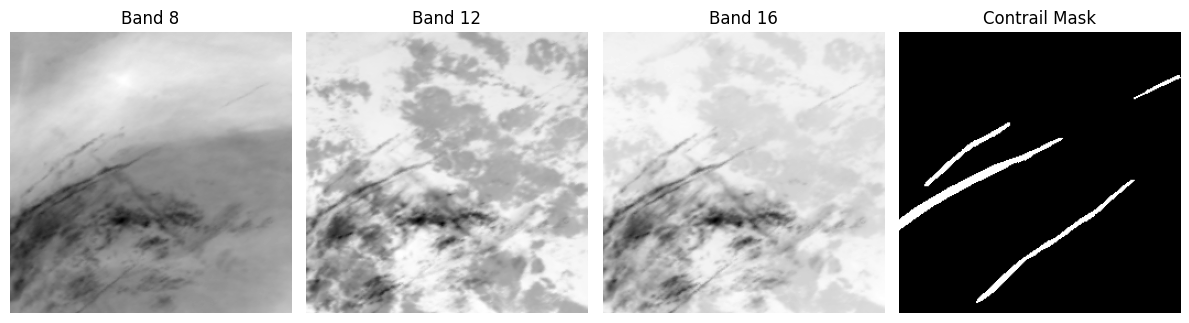

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
train_path = f"{base_path}/train"

# Pick one patch
for patch_id in os.listdir(train_path):
    mask = np.load(f"{train_path}/{patch_id}/human_pixel_masks.npy")
    if mask.ndim > 2:
        mask = mask[..., 0]
    if mask.max() > 0:
        print("Found patch with contrails:", patch_id)
        break

bands = []
for b in range(8, 17):  # bands 8–16
    band = np.load(f"{train_path}/{patch_id}/band_{b:02d}.npy")
    
    # Ensure 2D by taking the first channel if it's multi-channel
    if band.ndim > 2:
        band = band[..., 0]
    bands.append(band)

# Stack into a (H, W, 9) array
image = np.stack(bands, axis=-1)
print("Stacked image shape:", image.shape)  # should be (256, 256, 9)

# Load the contrail mask
mask = np.load(f"{train_path}/{patch_id}/human_pixel_masks.npy")
if mask.ndim > 2:
    mask = mask[..., 0]
print("Mask shape:", mask.shape)

# Visualize 3 selected bands and mask
plt.figure(figsize=(12, 6))
band_map = {8: 0, 12: 4, 16: 8}  # band number -> stacked index

for idx, b in enumerate([8, 12, 16]):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(image[..., band_map[b]], cmap='gray')
    plt.title(f"Band {b}")
    plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(mask, cmap='gray')
plt.title("Contrail Mask")
plt.axis("off")
plt.tight_layout()
plt.show()


### In this image we can see contrails appear

## Load & Preprocess Dataset

In [6]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

base_path = "/kaggle/input/google-research-identify-contrails-reduce-global-warming"
train_path = f"{base_path}/train"

# Load all patches
def load_data(train_path, bands_range=range(8, 17), max_patches=None):
    images = []
    masks = []
    patch_ids = os.listdir(train_path)
    if max_patches:
        patch_ids = patch_ids[:max_patches]

    for patch_id in patch_ids:
        patch_dir = os.path.join(train_path, patch_id)
        
        # Load bands
        band_list = []
        for b in bands_range:
            band = np.load(os.path.join(patch_dir, f"band_{b:02d}.npy"))
            if band.ndim > 2:
                band = band[..., 0]
            band_list.append(band)
        img = np.stack(band_list, axis=-1)  # (H, W, 9)
        img = img / np.max(img)  # normalize to 0-1
        
        # Load mask
        mask = np.load(os.path.join(patch_dir, "human_pixel_masks.npy"))
        if mask.ndim > 2:
            mask = mask[..., 0]
        mask = np.where(mask > 0, 1, 0)  # binary mask
        
        if mask.max() > 0:  # include only patches with contrails
            images.append(img)
            masks.append(mask)

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

# Load dataset (optionally limit number of patches for speed)
X, y = load_data(train_path, max_patches=50)
y = y[..., np.newaxis]  # add channel dimension for Keras (H,W,1)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


X shape: (21, 256, 256, 9)
y shape: (21, 256, 256, 1)


## Build U-Net Model

In [7]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization

# def unet(input_shape=(256, 256, 9)):
#     inputs = Input(input_shape)

#     # Encoder
#     c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
#     c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
#     p1 = MaxPooling2D(2)(c1)

#     c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
#     c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
#     p2 = MaxPooling2D(2)(c2)

#     c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
#     c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
#     p3 = MaxPooling2D(2)(c3)

#     c4 = Conv2D(256, 3, activation='relu', padding='same')(p3)
#     c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)
#     p4 = MaxPooling2D(2)(c4)

#     # Bottleneck
#     c5 = Conv2D(512, 3, activation='relu', padding='same')(p4)
#     c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)

#     # Decoder
#     u6 = Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv2D(256, 3, activation='relu', padding='same')(u6)
#     c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)

#     u7 = Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(128, 3, activation='relu', padding='same')(u7)
#     c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)

#     u8 = Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(64, 3, activation='relu', padding='same')(u8)
#     c8 = Conv2D(64, 3, activation='relu', padding='same')(c8)

#     u9 = Conv2DTranspose(32, 2, strides=2, padding='same')(c8)
#     u9 = concatenate([u9, c1])
#     c9 = Conv2D(32, 3, activation='relu', padding='same')(u9)
#     c9 = Conv2D(32, 3, activation='relu', padding='same')(c9)

#     outputs = Conv2D(1, 1, activation='sigmoid')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])
#     return model

# model = unet(input_shape=(256, 256, 9))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()



def unet(input_shape=(256,256,9)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32,3,activation='relu',padding='same')(inputs)
    c1 = Conv2D(32,3,activation='relu',padding='same')(c1)
    p1 = MaxPooling2D(2)(c1)

    c2 = Conv2D(64,3,activation='relu',padding='same')(p1)
    c2 = Conv2D(64,3,activation='relu',padding='same')(c2)
    p2 = MaxPooling2D(2)(c2)

    c3 = Conv2D(128,3,activation='relu',padding='same')(p2)
    c3 = Conv2D(128,3,activation='relu',padding='same')(c3)
    p3 = MaxPooling2D(2)(c3)

    c4 = Conv2D(256,3,activation='relu',padding='same')(p3)
    c4 = Conv2D(256,3,activation='relu',padding='same')(c4)
    p4 = MaxPooling2D(2)(c4)

    # Bottleneck
    c5 = Conv2D(512,3,activation='relu',padding='same')(p4)
    c5 = Conv2D(512,3,activation='relu',padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(256,2,strides=2,padding='same')(c5)
    u6 = concatenate([u6,c4])
    c6 = Conv2D(256,3,activation='relu',padding='same')(u6)
    c6 = Conv2D(256,3,activation='relu',padding='same')(c6)

    u7 = Conv2DTranspose(128,2,strides=2,padding='same')(c6)
    u7 = concatenate([u7,c3])
    c7 = Conv2D(128,3,activation='relu',padding='same')(u7)
    c7 = Conv2D(128,3,activation='relu',padding='same')(c7)

    u8 = Conv2DTranspose(64,2,strides=2,padding='same')(c7)
    u8 = concatenate([u8,c2])
    c8 = Conv2D(64,3,activation='relu',padding='same')(u8)
    c8 = Conv2D(64,3,activation='relu',padding='same')(c8)

    u9 = Conv2DTranspose(32,2,strides=2,padding='same')(c8)
    u9 = concatenate([u9,c1])
    c9 = Conv2D(32,3,activation='relu',padding='same')(u9)
    c9 = Conv2D(32,3,activation='relu',padding='same')(c9)

    outputs = Conv2D(1,1,activation='sigmoid')(c9)
    model = Model(inputs, outputs)
    return model

model = unet(input_shape=(256,256,9))
model.summary()



2025-10-18 07:37:03.724536: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 9)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      2,624 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,761,825 (29.61 MB)

 Trainable params: 7,761,825 (29.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth)/(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])


In [9]:
import random
import cv2

def augment_image_mask(image, mask):
    # Random horizontal flip
    if random.random() > 0.5:
        image = np.flip(image, axis=1)
        mask = np.flip(mask, axis=1)
    # Random vertical flip
    if random.random() > 0.5:
        image = np.flip(image, axis=0)
        mask = np.flip(mask, axis=0)
    # Random rotation (90,180,270)
    k = random.choice([0,1,2,3])
    image = np.rot90(image, k, axes=(0,1))
    mask = np.rot90(mask, k, axes=(0,1))
    return image, mask

def train_generator(X, y, batch_size=4):
    n = len(X)
    while True:
        idx = np.random.choice(n, batch_size)
        X_batch, y_batch = [], []
        for i in idx:
            img_aug, mask_aug = augment_image_mask(X[i], y[i])
            X_batch.append(img_aug)
            y_batch.append(mask_aug)
        yield np.array(X_batch), np.array(y_batch)


## Train the Model

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# checkpoint = ModelCheckpoint("unet_contrails.h5", save_best_only=True, monitor='val_loss')
# earlystop = EarlyStopping(monitor='val_loss', patience=10)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     batch_size=4,
#     epochs=50,
#     callbacks=[checkpoint, earlystop, reduce_lr]
# )


batch_size = 4
steps_per_epoch = len(X_train)//batch_size

checkpoint = tf.keras.callbacks.ModelCheckpoint("unet_contrails.h5", save_best_only=True, monitor='val_loss')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    train_generator(X_train, y_train, batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    callbacks=[checkpoint, earlystop, reduce_lr]
)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.4666 - loss: 1.7068 - val_accuracy: 0.9896 - val_loss: 1.3829 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9940 - loss: 1.2723 - val_accuracy: 0.9896 - val_loss: 1.0856 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9918 - loss: 1.0616 - val_accuracy: 0.9896 - val_loss: 1.0669 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9942 - loss: 1.0542 - val_accuracy: 0.9896 - val_loss: 1.0529 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9927 - loss: 1.0410 - val_accuracy: 0.9896 - val_loss: 1.0678 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9946 - loss: 1.0357 - val_accuracy: 0.9896 - val_loss: 1.0658 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9885 - loss: 1.0707 - val_accuracy: 0.9896 - val_l

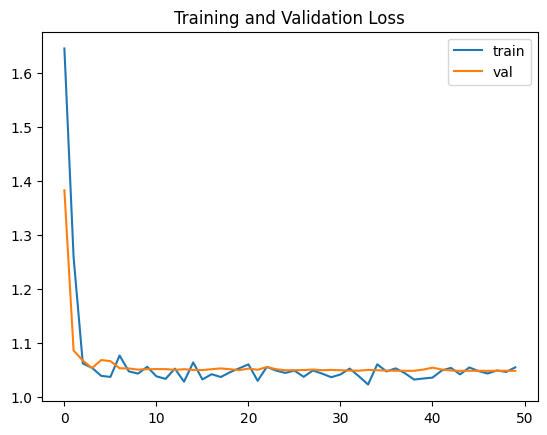

In [17]:
#training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

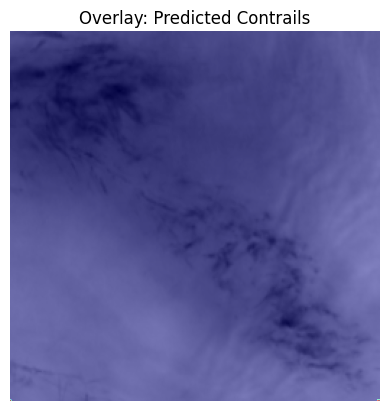

In [25]:

#plotting a few random masks overlayed on the original images
plt.imshow(X_val[i][...,0], cmap='gray')
plt.imshow(preds_binary[i][...,0], alpha=0.5, cmap='jet')
plt.title("Overlay: Predicted Contrails")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(5, 256, 256, 9) (5, 256, 256, 1) (5, 256, 256, 1)
1.0 0.11902704 1.0


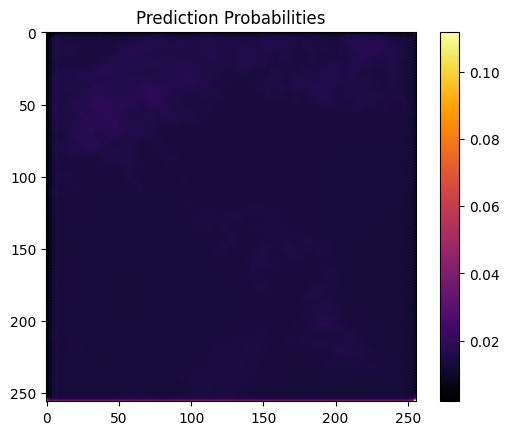

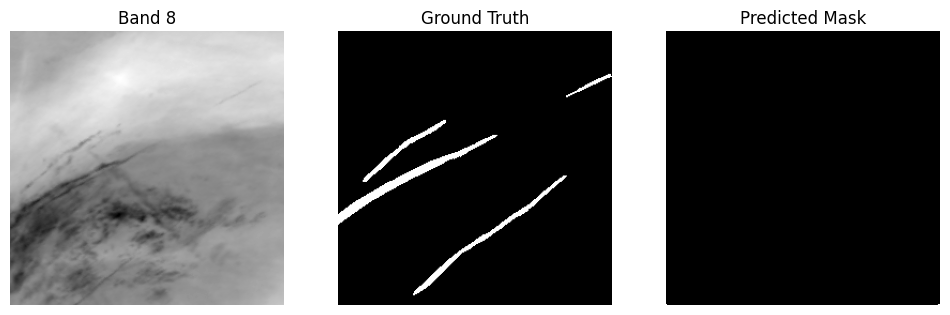

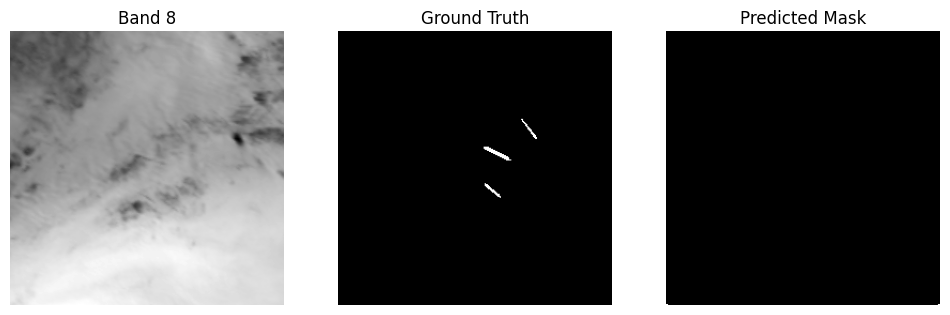

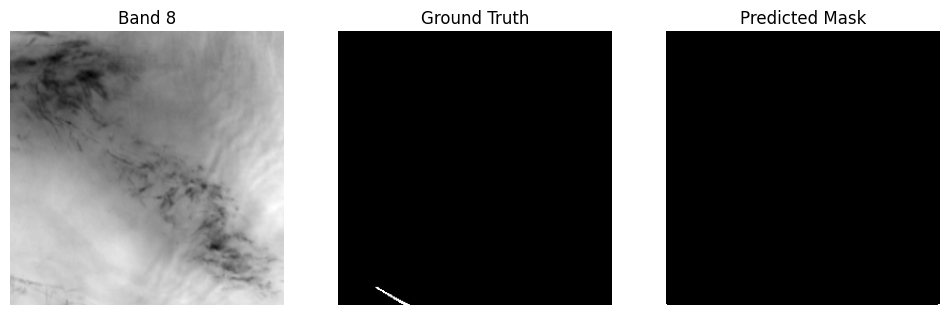

In [19]:
# import matplotlib.pyplot as plt

# # Load best model
# model.load_weights("unet_contrails.h5")

# # Predict
# preds = model.predict(X_val)

# # Threshold predictions
# preds_binary = (preds > 0.5).astype(np.uint8)

# # Visualize first sample
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 3, 1)
# plt.imshow(X_val[3][..., 0], cmap='gray')
# plt.title("Band 8 Input")
# plt.axis("off")

# plt.subplot(1, 3, 2)
# plt.imshow(y_val[3][..., 0], cmap='gray')
# plt.title("Ground Truth")
# plt.axis("off")

# plt.subplot(1, 3, 3)
# plt.imshow(preds_binary[3][..., 0], cmap='gray')
# plt.title("Predicted Mask")
# plt.axis("off")
# plt.show()


model.load_weights("unet_contrails.h5")
preds = model.predict(X_val)
preds_binary = (preds > 0.05).astype(np.uint8)  # lower threshold for thin contrails

#visualizing the raw probabilities
plt.imshow(preds[i][..., 0], cmap='inferno')
plt.colorbar()
plt.title("Prediction Probabilities")

#Ground truth misalignment or scaling issue
print(X_val.shape, y_val.shape, preds.shape)
print(np.max(X_val), np.max(preds), np.max(y_val))



# Visualize first 3 samples
for i in range(3):
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(X_val[i][...,0], cmap='gray')
    plt.title("Band 8")
    plt.axis("off")
    
    plt.subplot(1,3,2)
    plt.imshow(y_val[i][...,0], cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(1,3,3)
    plt.imshow(preds_binary[i][...,0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()

